In [75]:
import scanpy
import spatialdata

sdata = spatialdata.read_zarr("/Volumes/DATA_2025/Projects/RAO/dbs/Xenium_and_AdjustedPhenoCycler.V9.zarr")
adata = sdata.tables["GeneTranscripts_XStock_PhenCyc_Props_Ann"]
adata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/SOPA/lib/python3.10/site-packages/zarr/creati

AnnData object with n_obs × n_vars = 113273 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'DAPI_PhenCyc', 'CD8_PhenCyc', 'CD31_PhenCyc', 'CD11c_PhenCyc', 'CD34_PhenCyc', 'CD20_PhenCyc', 'CD4_PhenCyc', 'CD21_PhenCyc', 'Ki67_PhenCyc', 'CD68_PhenCyc', 'E_cadherin_PhenCyc', 'pten_PhenCyc', 'NF-H_PhenCyc', 'FOXp3_PhenCyc', 'CD45_PhenCyc', 'TFAM_PhenCyc', 'PDL-1_PhenCyc', 'SOX2_PhenCyc', 'Vimentin_PhenCyc', 'HIF1A_PhenCyc', 'CD44_PhenCyc', 'Keratin_8_18_PhenCyc', 'aSMA_PhenCyc', 'EpCAM_PhenCyc', 'K14_PhenCyc', 'area', 'centroid-0', 'centroid-1', 'centroid_local-1', 'centroid_weighted_local-0', 'centroid_weighted_local-1', 'euler_number', 'extent', 'feret_diameter_max', 'intensity_max', 'intensity_min', 'intensity_mean', 'solidity', 'ecc

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.pyplot as plt

def query_regression(adata, feature, cell_type, goi, plot=True):
    """
    Perform linear regression of gene expression against a feature.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    feature : str
        The feature to regress against.
    cell_type : str
        The cell type to filter on.
    goi : str
        Gene of interest.
    plot : bool
        Whether to plot the results.
    
    Returns
    -------
    res : LinregressResult
        The result of the linear regression.
    """
    is_chosen = adata.obs["cell_type_manuel"] == cell_type
    adata_chosen = adata[is_chosen].copy()

    expr = adata_chosen[:, goi].X
    x = expr.toarray().flatten() if hasattr(expr, "toarray") else expr.flatten()
    y = adata_chosen.obs[feature].astype(float).values
    #x, y = x[x >= 0], y[x >= 0]
    res = linregress(x, y)

    if plot:
        plt.figure(figsize=(6,6), dpi=150)
        plt.scatter(x, y, s=10, alpha=0.6, label=cell_type)


        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = res.intercept + res.slope * x_line
        plt.plot(x_line, y_line, c="red", lw=2,
                label=f"y={res.slope:.2f}x+{res.intercept:.1f}")
        plt.xlabel(goi+" expression")
        plt.ylabel(feature)
        plt.title(goi + f" vs {feature} {cell_type}\n"
                f"R²={res.rvalue**2:.3f}, p={res.pvalue:.2e}")
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

    return res



def get_top_genes(adata, top=200):            
    # 2) Compute dispersion for every gene = var / mean
    #    adata_tumor.X may be sparse → convert to dense or use .toarray()
    Xmat = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    means = Xmat.mean(axis=0)
    vars_  = Xmat.var(axis=0, ddof=1)

    # avoid division by zero
    dispersion = vars_ / (means + 1e-12)

    # 3) Pick the top-100 most dispersed gene indices
    top_idx = np.argsort(dispersion)[-top:][::-1]
    top_genes = adata_chosen.var_names[top_idx]
    
    return top_genes



def forest_plot_regression(
    adata,
    feature,
    cell_type,
    gois,
    alpha=0.05
):
    """
    For each gene in `gois`, run query_regression (with plot=False),
    collect slope ± 1.96*stderr, and draw a horizontal forest plot.
    Returns a DataFrame of results.
    """
    records = []
    for gene in gois:
        res = query_regression(adata, feature, cell_type, gene, plot=False)
        slope = res.slope
        se    = res.stderr
        # 95% CI
        z = abs(np.percentile(np.random.standard_normal(1000000), [100*alpha/2]))[0]  # ~1.96
        ci_low  = slope - z*se
        ci_high = slope + z*se
        records.append((gene, slope, ci_low, ci_high))
    
    df = pd.DataFrame(records, columns=['gene','slope','ci_low','ci_high'])
    df = df.sort_values('slope').reset_index(drop=True)

    # forest plot
    fig, ax = plt.subplots(figsize=(6, max(4, len(gois)*0.4)), dpi=150)
    y_pos = np.arange(len(df))
    errs  = np.vstack([df['slope']-df['ci_low'], df['ci_high']-df['slope']])
    
    ax.errorbar(
        df['slope'], y_pos,
        xerr=errs,
        fmt='o',
        capsize=4
    )
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['gene'])
    ax.set_xlabel('Slope (with 95% CI)')
    ax.set_title(f"{cell_type!r}: {feature!r} forest plot")
    plt.tight_layout()
    plt.show()

    return df


## Extracted Feature Distribution

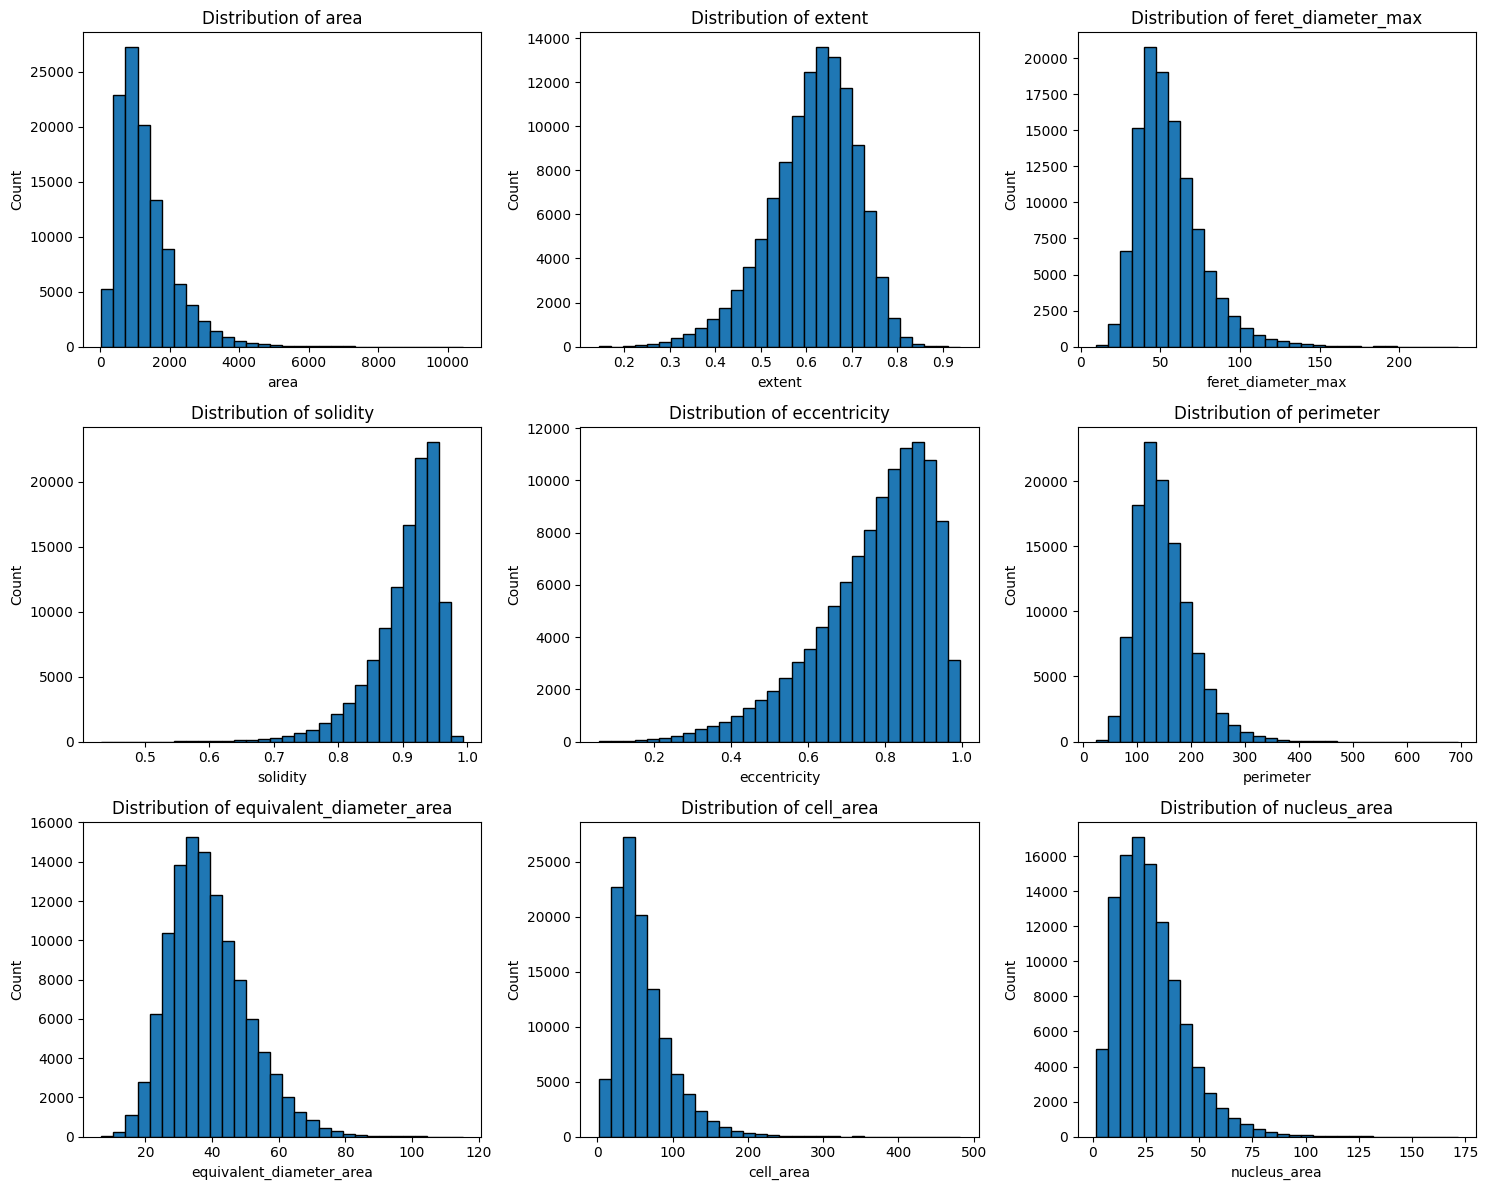

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

features = [
    'area', 'extent', 'feret_diameter_max',
    'solidity', 'eccentricity', 'perimeter',
    'equivalent_diameter_area', 'cell_area', 'nucleus_area'
]

# coerce to numeric (errors → NaN)
df = adata.obs[features].apply(pd.to_numeric, errors='coerce')

# set up 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    vals = df[feat].dropna()
    ax.hist(vals, bins=30, edgecolor='black')
    ax.set_title(f'Distribution of {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')

fig.tight_layout()
plt.show()

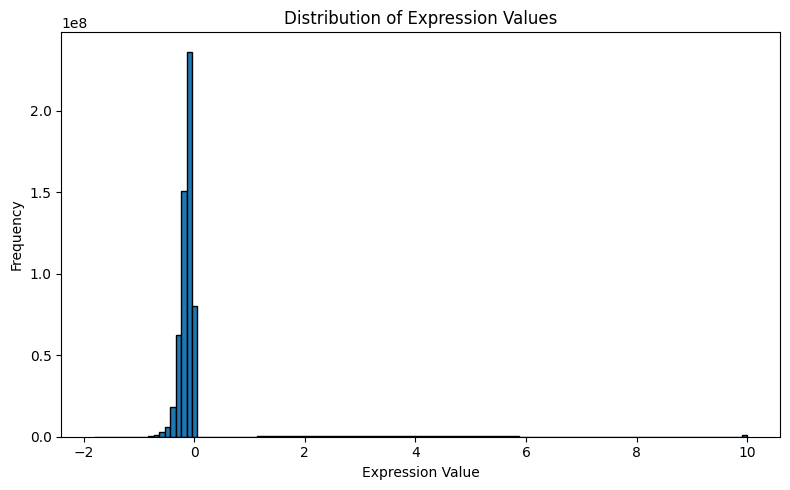

In [84]:
plt.figure(figsize=(8, 5))
plt.hist(adata.X.flatten(), bins=120, edgecolor='black')
plt.title("Distribution of Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

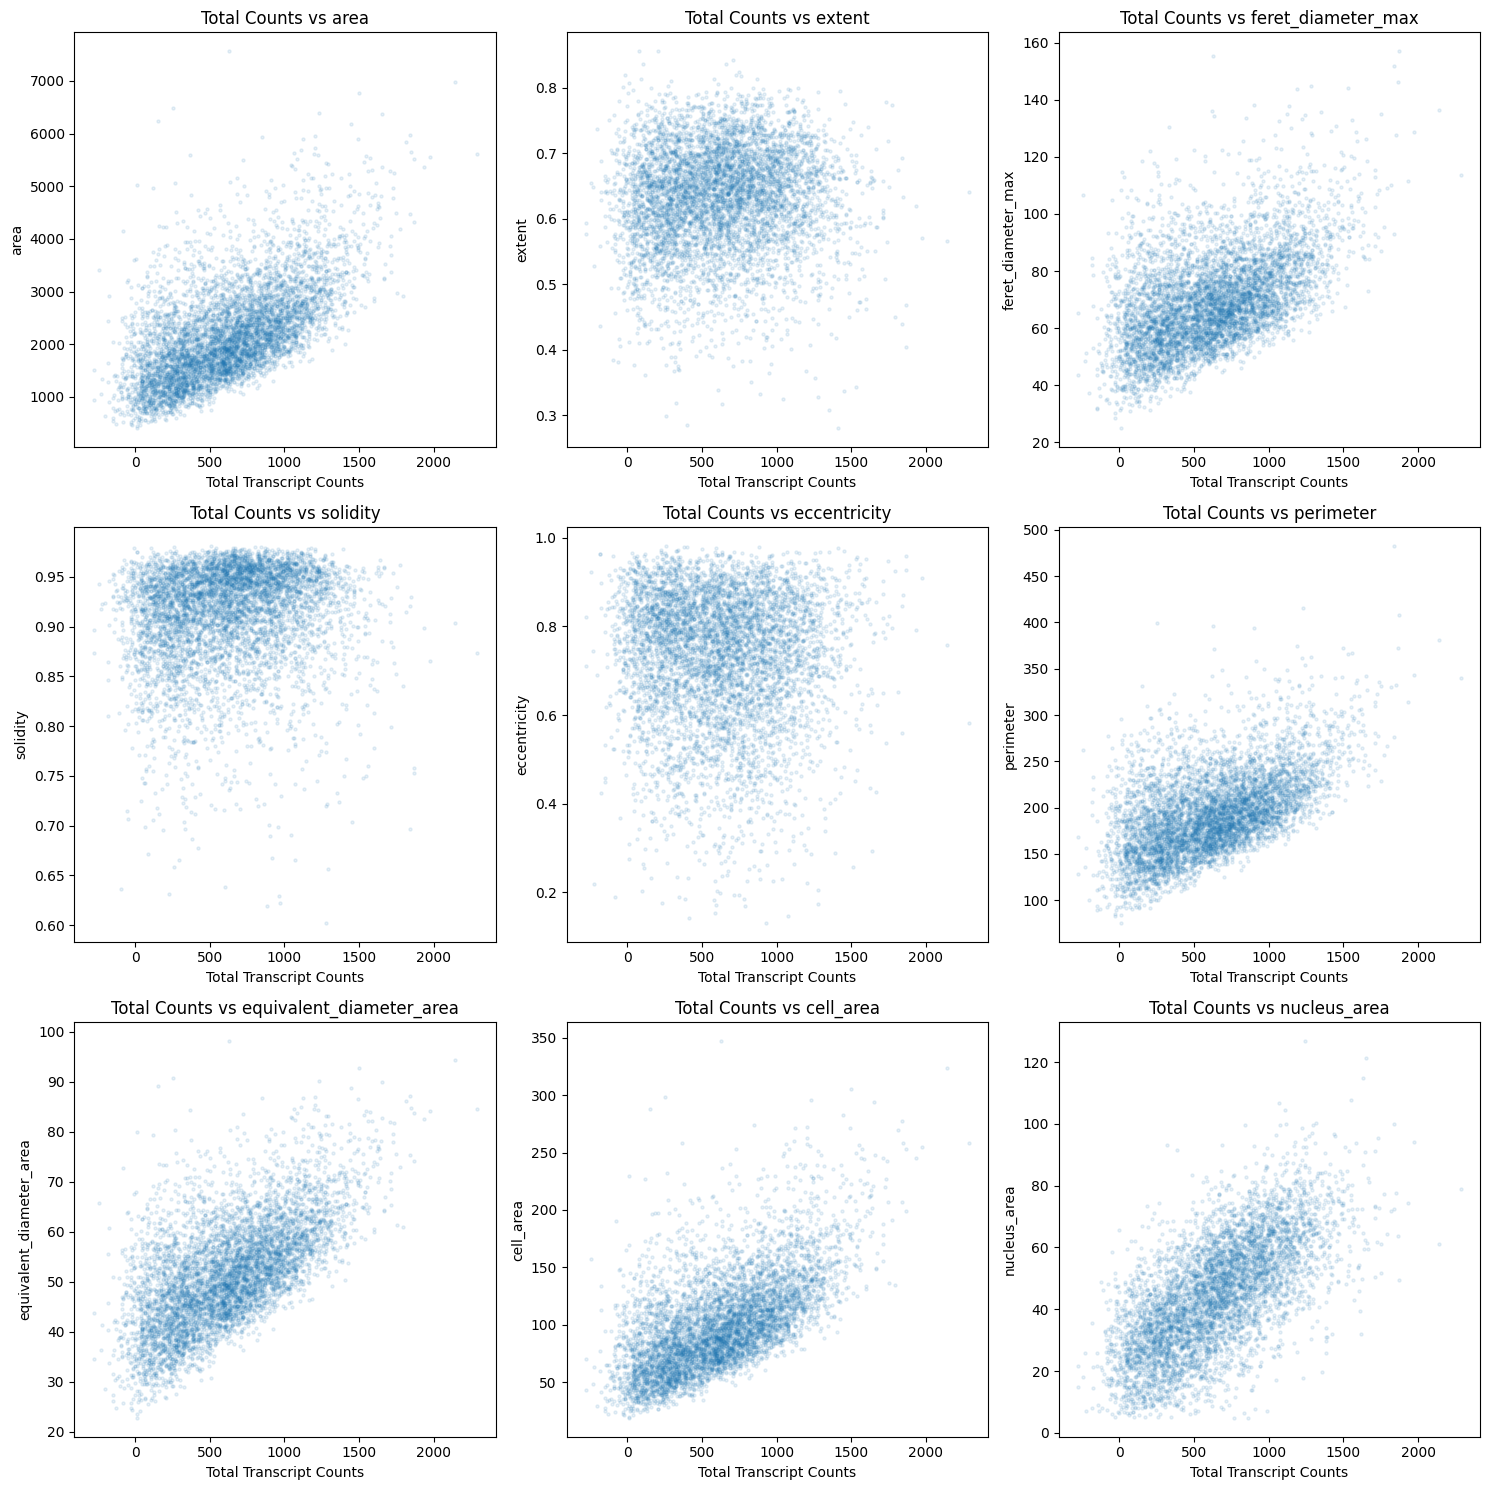

In [74]:
adata_rec = adata.copy()
adata = adata_rec

features = [
    'area', 'extent', 'feret_diameter_max',
    'solidity', 'eccentricity', 'perimeter',
    'equivalent_diameter_area', 'cell_area', 'nucleus_area'
]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#is_chosen = adata.obs["cell_type_manuel"] == "Tumor"
#adata_chosen = adata[is_chosen].copy()
#X = adata_chosen.X
#adata = adata_chosen

#gois = get_top_genes(adata, top = 50)
#X = adata[:, gois].X

# 1) Compute total transcript counts per cell
#X = adata.X
if hasattr(X, "toarray"):
    total_counts = np.array(X.toarray()).sum(axis=1)
else:
    total_counts = np.array(X).sum(axis=1)
adata.obs['total_counts'] = total_counts


plot_feats = [f for f in features if f in adata.obs.columns][:9]

# 3) Convert to numeric
df = adata.obs[plot_feats].apply(pd.to_numeric, errors='coerce')
df['total_counts'] = adata.obs['total_counts']

# 4) Plot 3×3 scatter grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, feat in zip(axes, plot_feats):
    mask = df[feat].notna()
    ax.scatter(df['total_counts'][mask], df[feat][mask], s=5, alpha=0.1)
    ax.set_xlabel('Total Transcript Counts')
    ax.set_ylabel(feat)
    ax.set_title(f'Total Counts vs {feat}')

fig.tight_layout()
plt.show()

# Show all gene expression and feature correlations for all features


## Define Regression Function

In [ ]:
import numpy  as np
import pandas as pd
from scipy.stats import linregress


adata.obs['cell_type_manuel'] = (
    adata.obs['cell_type_manuel']
        .str.replace(" ", "_", regex=False)
        .str.replace("/", "OR",   regex=False)
        .str.replace(",", "AND",   regex=False)
        .str.replace("+", "",   regex=False)
        .str.replace(")", "_",   regex=False)
        .str.replace("(", "_",   regex=False)

)



# New informative column
adata.obs['nucleus_by_cell_area'] = (
    pd.to_numeric(adata.obs['nucleus_area'], errors='coerce') /
    pd.to_numeric(adata.obs['cell_area'], errors='coerce')
).replace([np.inf, -np.inf], np.nan)



c = 0 

records = []
for feature in features:
    for cell_type in set(adata.obs["cell_type_manuel"].to_list()):
        
        is_chosen = adata.obs["cell_type_manuel"] == cell_type
        adata_chosen = adata[is_chosen].copy()
        for goi in get_top_genes(adata, top = 100):
            print(feature,cell_type,goi)
            

            expr = adata_chosen[:, goi].X
            x = expr.toarray().flatten() if hasattr(expr, "toarray") else expr.flatten()
            y = adata_chosen.obs[feature].astype(float).values
            x, y = x[x >= 0], y[x >= 0]
            if x.shape[0] < 30:
                continue
            
            try:
                res = linregress(x, y)

                records.append({
                "feature":      feature,
                "cell_type":    cell_type,
                "transcript":   goi,
                "slope":        res.slope,
                "intercept":    res.intercept,
                "r_value":      res.rvalue,
                "r_squared":    res.rvalue**2,
                "p_value":      res.pvalue,
                "stderr":       res.stderr
            })


            except:
                records.append({
                "feature":      feature,
                "cell_type":    cell_type,
                "transcript":   goi,
                "slope":        None,
                "intercept":    None,
                "r_value":      None,
                "r_squared":    None,
                "p_value":      None,
                "stderr":       None
            })
                c += 1
                print("Error in linregress")


            # 4) Plot
            # plt.figure(figsize=(6,6), dpi=150)
            # plt.scatter(x, y, s=10, alpha=0.6, label=cell_type)


            # x_line = np.linspace(x.min(), x.max(), 100)
            # y_line = res.intercept + res.slope * x_line
            # plt.plot(x_line, y_line, c="red", lw=2,
            #         label=f"y={res.slope:.2f}x+{res.intercept:.1f}")
            # plt.xlabel(goi+" expression")
            # plt.ylabel(feature)
            # plt.title(goi + f" vs {feature} (Tumor cells)\n"
            #         f"R²={res.rvalue**2:.3f}, p={res.pvalue:.2e}")
            # plt.legend(fontsize=8)
            # plt.tight_layout()
            # plt.show()
    



area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ RAP2A
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ RASD1
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ AKT2
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ MFGE8
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ RC3H2
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ TSPAN9
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ GOT1
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ NT5C2
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ STRN3
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ MAP4K5
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ PGD
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ RBMS3
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ EPDR1
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ ACPP
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ MAP7D1
area Vascular_Endothelial_1__CD31_and_CD34_both_groups_ CUL1
area Vascul

In [38]:
#adata_chosen.obs["cell_type_manuel"]

expr = adata_chosen[:, goi].X

x = expr.toarray().flatten() if hasattr(expr, "toarray") else expr.flatten()
x
# y = adata_chosen.obs[feature].astype(float).values
# x, y = x[x >= 0], y[x >= 0]

array([-0.1939943, -0.1939943, -0.1939943, ..., -0.1939943, -0.1939943,
       -0.1939943], shape=(4055,), dtype=float32)

In [44]:
import pandas as pd

df_regs = pd.DataFrame(records).sort_values(by="p_value")
df_regs.head(50)

,feature,cell_type,transcript,slope,intercept,r_value,r_squared,p_value,stderr
13890,equivalent_diameter_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,1.391280,47.767911,0.175045,0.030641,3.332281e-113,0.061050
13859,equivalent_diameter_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,1.614726,48.154809,0.170638,0.029117,1.367404e-107,0.072742
15990,cell_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,5.233303,86.231075,0.167651,0.028107,7.169517e-104,0.240083
1290,area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,113.405896,1866.977266,0.167633,0.028101,7.528783e-104,5.203159
1259,area,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,132.391788,1898.061765,0.164372,0.027018,7.203983e-100,6.198211
15959,cell_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,6.101422,87.670216,0.164173,0.026953,1.252096e-99,0.286007
11790,perimeter,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,6.007736,180.045146,0.161969,0.026234,5.477320e-97,0.285554
13571,equivalent_diameter_area,Follicular_Dendritic__has_aSMA__OR_mature_B_cell,SLMAP,1.505811,41.212168,0.212905,0.045328,2.251367e-92,0.073010
13596,equivalent_diameter_area,Follicular_Dendritic__has_aSMA__OR_mature_B_cell,MXRA7,1.831442,40.631115,0.209879,0.044049,9.196088e-90,0.090139
11759,perimeter,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,6.842324,181.792122,0.154941,0.024007,8.097613e-89,0.340362


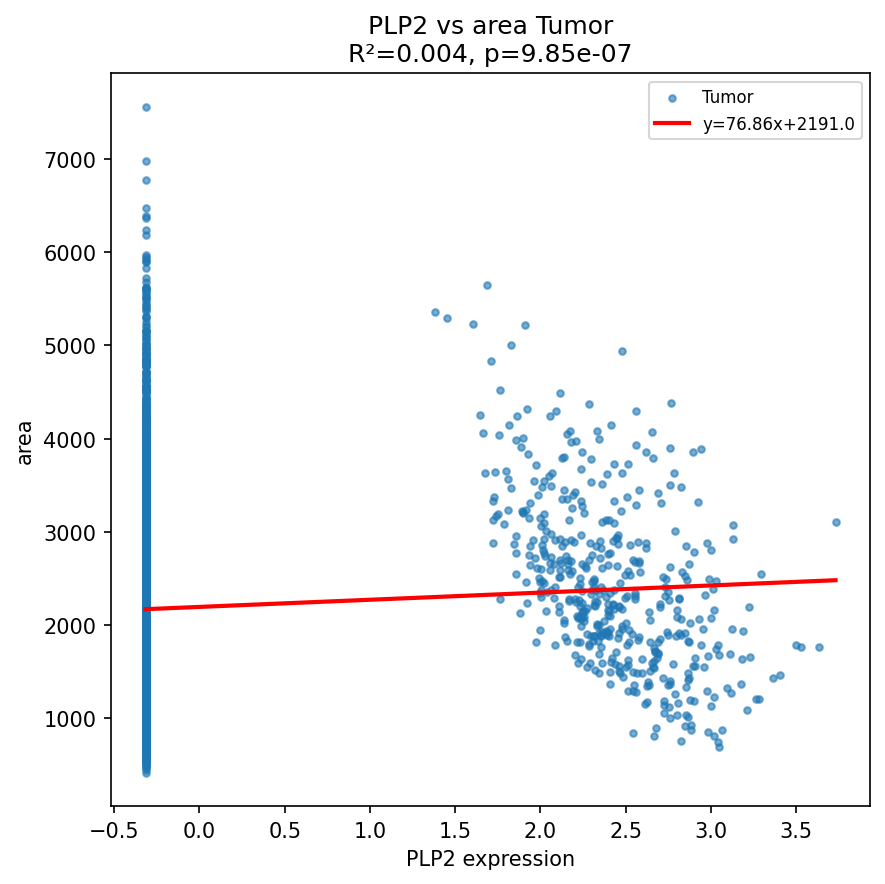

LinregressResult(slope=np.float64(76.85597961733461), intercept=np.float64(2191.004541504124), rvalue=np.float64(0.06511367241245106), pvalue=np.float64(9.851756860099499e-07), stderr=np.float64(15.684901978653182), intercept_stderr=np.float64(11.918593635449026))

In [53]:
adata.obs['nucleus_by_cell_area'] = (
    pd.to_numeric(adata.obs['nucleus_area'], errors='coerce') /
    pd.to_numeric(adata.obs['cell_area'], errors='coerce')
).replace([np.inf, -np.inf], np.nan)

query_regression(adata, "area", "Tumor", "PLP2", plot=True)

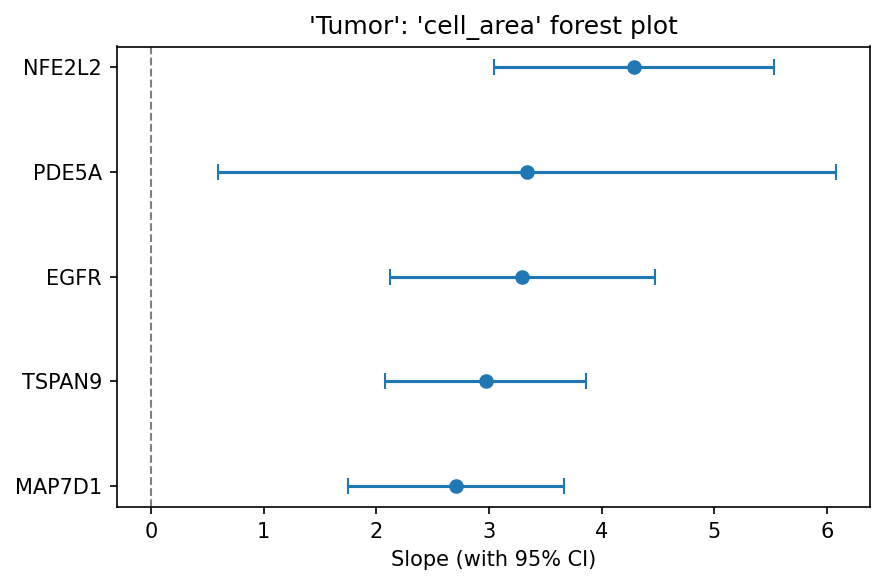

     gene     slope    ci_low   ci_high
0  MAP7D1  2.708578  1.748551  3.668606
1  TSPAN9  2.970121  2.078861  3.861381
2    EGFR  3.296241  2.119408  4.473074
3   PDE5A  3.338482  0.597414  6.079550
4  NFE2L2  4.287062  3.045725  5.528399


In [52]:
genes = ['MAP7D1','PDE5A',"TSPAN9", "EGFR", "NFE2L2"]
df_forest = forest_plot_regression(
    adata,
    feature='cell_area',
    cell_type='Tumor',
    gois=genes
)
print(df_forest)

In [47]:
import numpy as np

# critical value for 95% CI
z = 1.96

# compute CIs
df_regs['ci_low']  = df_regs['slope'] - z * df_regs['stderr']
df_regs['ci_high'] = df_regs['slope'] + z * df_regs['stderr']

# keep only genes whose 95% CI does *not* cross zero
df_reg_sign = df_regs[(df_regs['ci_low'] > 0) | (df_regs['ci_high'] < 0)].copy()
df_regs_conf = df_reg_sign[df_reg_sign['p_value'] < 0.05]

In [48]:
df_regs_conf

,feature,cell_type,transcript,slope,intercept,r_value,r_squared,p_value,stderr,ci_low,ci_high
13890,equivalent_diameter_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,1.391280,47.767911,0.175045,0.030641,3.332281e-113,0.061050,1.271621,1.510939e+00
13859,equivalent_diameter_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,1.614726,48.154809,0.170638,0.029117,1.367404e-107,0.072742,1.472151,1.757301e+00
15990,cell_area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,5.233303,86.231075,0.167651,0.028107,7.169517e-104,0.240083,4.762741,5.703866e+00
1290,area,Luminal_Epithelial__SureAND_Keratin8OR18__1,POR,113.405896,1866.977266,0.167633,0.028101,7.528783e-104,5.203159,103.207705,1.236041e+02
1259,area,Luminal_Epithelial__SureAND_Keratin8OR18__1,CANX,132.391788,1898.061765,0.164372,0.027018,7.203983e-100,6.198211,120.243294,1.445403e+02
...,...,...,...,...,...,...,...,...,...,...,...
4729,feret_diameter_max,Urethelial_Cells,OPTN,0.348629,44.390347,0.019846,0.000394,4.986608e-02,0.177749,0.000241,6.970165e-01
1070,area,Luminal_Epithelial__SureAND_Keratin8OR18__2,ATIC,11.383629,1017.572094,0.023648,0.000559,4.993203e-02,5.805334,0.005174,2.276208e+01
3525,extent,Plasmacytoid_dendritic_cells_or_B_cell_memory_...,FAM98A,0.003469,0.605720,0.050311,0.002531,4.994144e-02,0.001768,0.000004,6.933995e-03
8084,solidity,Macrophages_M2_Like__For_sure_CD68_,CBX3,-0.001534,0.899257,-0.027646,0.000764,4.994649e-02,0.000782,-0.003066,-6.993523e-07


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV

def find_causal_genes(adata, df_regs, cell_type, feature="cell_area"):
    # 1) pull out candidates
    candidates = (
        df_regs
          .query("cell_type == @cell_type and feature == @feature")
          .transcript
          .unique()
          .tolist()
    )
    
    # 2) subset adata to just that cell type
    mask = adata.obs["cell_type_manuel"] == cell_type
    ad = adata[mask]
    
    # 3) build X (cells × genes) and y
    X = ad[:, candidates].X
    X = X.toarray() if hasattr(X, "toarray") else X
    y = pd.to_numeric(ad.obs[feature], errors="coerce").values
    
    # drop any cells with missing y
    valid = ~np.isnan(y)
    X, y = X[valid], y[valid]
    
    # —— a) multivariate OLS ——
    X_ols = sm.add_constant(X)
    ols = sm.OLS(y, X_ols).fit()
    df_ols = pd.DataFrame({
        "gene": ["intercept"] + candidates,
        "coef":  ols.params,
        "pval":  ols.pvalues
    }).sort_values("coef", key=lambda s: s.abs(), ascending=False)
    
    # —— b) LASSO for feature‐selection ——
    lasso = LassoCV(cv=5, random_state=0).fit(X, y)
    df_lasso = pd.Series(lasso.coef_, index=candidates, name="lasso_coef")
    df_lasso = df_lasso[df_lasso.abs() > 1e-6].sort_values(key=lambda s: s.abs(), ascending=False)
    
    return df_ols, df_lasso

# usage
df_ols, df_lasso = find_causal_genes(
    adata,
    df_regs,
    cell_type="Tumor",       # or whatever label you’re using
    feature="cell_area"
)

print("=== multivariate OLS (coef, p-value) ===")
print(df_ols)

print("\n=== LASSO-selected genes ===")
print(df_lasso.head(50))

=== multivariate OLS (coef, p-value) ===
          gene       coef           pval
0    intercept  60.992881  8.210675e-149
482       CCL5   5.598587   4.158912e-13
470       GAS6   4.301751   4.119500e-03
330     SNHG15   4.151807   2.459613e-17
476      AEBP1   3.680101   1.316884e-02
..         ...        ...            ...
142      IKBKB  -0.004122   9.901189e-01
454        TNC  -0.001509   9.984030e-01
146       POLB   0.001386   9.948358e-01
276      ASCC3  -0.000828   9.981480e-01
322     ADAM17  -0.000191   9.995940e-01

[489 rows x 3 columns]

=== LASSO-selected genes ===
CCL5         5.608944
SNHG15       4.226966
SOX2-OT      2.513174
SORD         2.082844
DKK3         2.008047
THBS1        2.000137
MYH9         1.993520
IL6ST        1.956745
RRAS         1.825447
WFDC1        1.673826
CORO1C       1.592432
OLFML3       1.585624
PRKACA       1.563356
IGF2R        1.534339
SOD3         1.428290
HK1          1.398469
TGFB3        1.382855
RANBP9       1.320438
LDHA         1.31

In [ ]:
# import pandas as pd

# # 1) pick only the cell_area rows and pad with your q‐value threshold
# sig = df_regs[
#     (df_regs.feature == "cell_area")
# ].copy()

# # 2) presence matrix: one row per gene, one col per cell_type
# presence = pd.crosstab(index=sig["transcript"], columns=sig["cell_type"])
# # values are counts (1 if present per our table), fill zeros automatically

# print("=== genes × cell_types presence ===")
# print(presence)

# 3) if you want an adjacency of cell_types showing shared genes
#    (Tumor vs Urothelial, etc.), just do:
#adjacency = presence.T.dot(presence)
#print("\n=== cell_type × cell_type shared‐gene counts ===")
#adjacency

In [55]:
df_reg_sign[
	(df_reg_sign["slope"] < 0) &
	(df_reg_sign["feature"] == "area")].sort_values("p_value").head(50)

,feature,cell_type,transcript,slope,intercept,r_value,r_squared,p_value,stderr,ci_low,ci_high
562,area,Urethelial_Cells,ANXA1,-13.96219,851.068779,-0.022932,0.000526,0.023443,6.160252,-26.036283,-1.888098
1367,area,Tumor_-_StemCell_Like,IQGAP2,-18.29780,1354.757607,-0.024056,0.000579,0.040071,8.911052,-35.763462,-0.832138
1047,area,Luminal_Epithelial__SureAND_Keratin8OR18__2,CYFIP2,-11.34782,1016.853165,-0.024419,0.000596,0.042918,5.604195,-22.332042,-0.363598


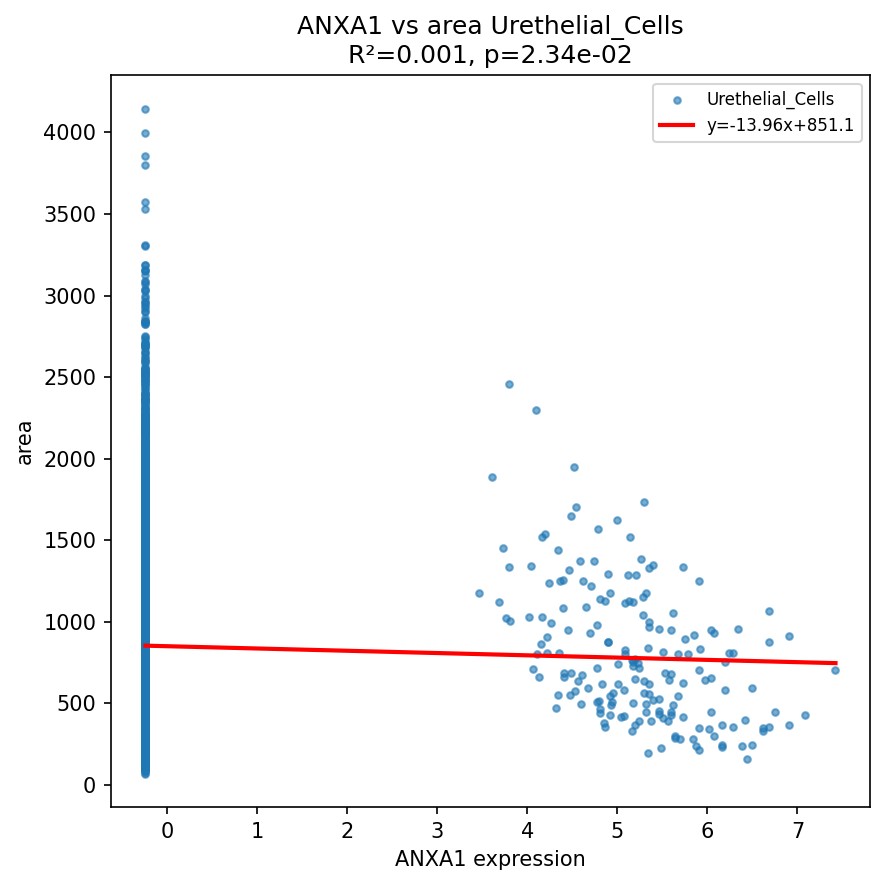

LinregressResult(slope=np.float64(-13.962190488731009), intercept=np.float64(851.0687794959553), rvalue=np.float64(-0.022932386003466202), pvalue=np.float64(0.023442767611482403), stderr=np.float64(6.1602515172569605), intercept_stderr=np.float64(4.631547048256867))

In [56]:
query_regression(adata, "area", "Urethelial_Cells", "ANXA1", plot=True)